# Synthetic Data Generation

In [ ]:
import random

def generate_power_rule_data(num_samples=2000, max_coeff=1, max_exp=200):
    dataset = []
    seen = set()

    while len(dataset) < num_samples:
        #coeff = random.randint(1, max_coeff)
        coeff = 1
        exp = random.randint(2, max_exp) # Start at 2 so derivative isn't just a constant

        # Format: d(ax^n)=
        # We handle the case where coeff is 1 (e.g., d(x^3)=)
        if coeff == 1:
            input_str = f"d(x^{exp})="
        else:
            input_str = f"d({coeff}x^{exp})="

        # Calculation for Power Rule: (coeff * exp)x^(exp-1)
        new_coeff = coeff * exp
        new_exp = exp - 1

        if new_exp == 1:
            output_str = f"{new_coeff}x"
        else:
            output_str = f"{new_coeff}x^{new_exp}"

        # Ensure unique samples to prevent memorization of the same 10 problems
        # if input_str not in seen:
        #     dataset.append((input_str, output_str))
        #     seen.add(input_str)


        dataset.append((input_str, output_str))
        #seen.add(input_str)

    return dataset

# Generate 1,000 unique samples
power_rule_data = generate_power_rule_data(5000)

# Print samples to verify formatting
for i in range(5):
    print(f"Input: {power_rule_data[i][0]:<15} | Output: {power_rule_data[i][1]}")
    #print(power_rule_data[i])

Input: d(x^172)=       | Output: 172x^171
Input: d(x^51)=        | Output: 51x^50
Input: d(x^126)=       | Output: 126x^125
Input: d(x^121)=       | Output: 121x^120
Input: d(x^73)=        | Output: 73x^72


# Build Vocabulary and define tokenizer

In [ ]:
# 1. Join every single question and answer in your dataset into one giant string.
all_text = "".join([q + a for q, a in power_rule_data])


# 2. Extract every unique character and sort them alphabetically.
# Result looks like: ['(', ')', '0', '1', ..., '=', '^', 'd', 'x']
chars = sorted(list(set(all_text)))

# 3
# The correct way to build the vocab. Add special token first
special_tokens = ["<pad>", "<eos>"]
# (Assuming 'chars' contains your math symbols like x, ^, 0-9)
vocab = {token: i for i, token in enumerate(special_tokens)}

# 4. Create a Dictionary where the Character is the KEY and its Rank is the VALUE.
# Result: {'(': 1, ')': 2, ...}
# Add the rest of the characters starting from index 2
for i, char in enumerate(chars):
    if char not in vocab:
        vocab[char] = len(vocab)

# 5. Create a reverse dictionary.
# This is for US to read. It turns the model's numerical output back into math text.
inverse_vocab = {i: char for char, i in vocab.items()}

print(f"Vocab: {vocab}")
print(f"Inverse Vocab: {inverse_vocab}")

Vocab: {'<pad>': 0, '<eos>': 1, '(': 2, ')': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, '=': 14, '^': 15, 'd': 16, 'x': 17}
Inverse Vocab: {0: '<pad>', 1: '<eos>', 2: '(', 3: ')', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: '=', 15: '^', 16: 'd', 17: 'x'}


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

class CalculusDataset(Dataset):
    def __init__(self, data, vocab, max_len=32):
        self.samples = []

        eos_id = vocab["<eos>"]
        pad_id = vocab["<pad>"]
        for q, a in data:
            # Combine question and answer: "d(x^3)=3x^2<eos>"
            full_text = q + a

            # Convert characters to numbers using your vocab
            tokens = [vocab.get(c, 0) for c in full_text]
            tokens.append(eos_id)

            # Padding to match n_ctx (32)
            if len(tokens) < max_len:
                tokens += [0] * (max_len - len(tokens))
            else:
                tokens = tokens[:max_len]

            self.samples.append(torch.tensor(tokens))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# 1. Initialize your dataset
# (Assuming 'vocab' is the dictionary we built earlier)
train_ds = CalculusDataset(power_rule_data, vocab, max_len=32)

# 2. Define the Loader
# This is what you pass into train_model(model, loader)
loader = DataLoader(train_ds, batch_size=16, shuffle=True)

# Grab exactly one batch
first_batch = next(iter(loader))

# If your dataset returns (input, target) pairs:
inputs= first_batch
print("Input Shape:", inputs.shape)
print("First 3 Inputs (Raw Tokens):\n", inputs[:3])

Input Shape: torch.Size([16, 32])
First 3 Inputs (Raw Tokens):
 tensor([[16,  2, 17, 15, 10,  7,  3, 14, 10,  7, 17, 15, 10,  6,  1,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [16,  2, 17, 15,  5,  8, 11,  3, 14,  5,  8, 11, 17, 15,  5,  8, 10,  1,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [16,  2, 17, 15,  5,  5, 13,  3, 14,  5,  5, 13, 17, 15,  5,  5, 12,  1,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])


In [ ]:
def tokenize(text, max_len=32):
    # 1. Look up each character 'c' in our vocab dictionary and get its number.
    # If text is "d(x^2)", tokens becomes [7, 1, 19, 16, 5]
    tokens = [vocab[c] for c in text]

    # 2. Calculate how much 'dead space' is left compared to our maximum length.
    # If our string is 5 chars and max_len is 20, we need 15 zeros.
    padding_needed = max_len - len(tokens)

    # 3. Append the zeros (<pad>) to the end so every sequence is exactly max_len.
    return tokens + [0] * padding_needed

# Model Definition and Training


In [ ]:
!pip install transformer_lens

In [ ]:
import torch
import torch.nn as nn
from transformer_lens import HookedTransformer, HookedTransformerConfig

# The transformer_lens is taking care of the embedding matrix. The matris has a size of 128 values (hidden dimension)

# 1. Define the configuration
model_def = HookedTransformerConfig(
    n_layers=2,            # Small enough to reverse-engineer
    d_model=64,           # The width of the "residual stream" / hidden dimension of model
    n_ctx=32,              # Max length of math expressions
    d_head=32,             # Dimension of each attention head
    n_heads=4,             # Number of heads per layer
    d_mlp=256,             # Size of the feed-forward layers: 1st: hidden x 512; 2nd: 512 x hidden
    d_vocab=len(vocab),    # Size of vocab (should have (), numbers, +,- etc)
    act_fn="relu",         # Standard; easier to interpret with SAEs
    normalization_type="LN", # LayerNorm
    device="cuda" if torch.cuda.is_available() else "cpu"
)

# 2. Instantiate the model
model = HookedTransformer(model_def)

In [ ]:
# import torch
# import torch.nn as nn

# # 1. Setup
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=0.01)
# loss_fn = nn.CrossEntropyLoss(ignore_index=0)

# def train_model(model, loader, epochs=50):
#     model.train()
#     for epoch in range(epochs):
#         total_loss = 0
#         for batch in loader:
#             # batch shape: [batch_size, n_ctx]
#             batch = batch.to(model.cfg.device)

#             # Forward pass
#             logits = model(batch)

#             # The "Shift": Predict NEXT token
#             # Logits: [d, (, x, ^, 3, ), =, 3, x, ^]
#             # Targets: [(, x, ^, 3, ), =, 3, x, ^, 2]
#             predictions = logits[:, :-1, :]
#             targets = batch[:, 1:]

#             loss = loss_fn(
#                 predictions.reshape(-1, model.cfg.d_vocab),
#                 targets.reshape(-1)
#             )

#             # Backward pass
#             loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()

#             total_loss += loss.item()

#         if epoch % 10 == 0:
#             print(f"Epoch {epoch} | Loss: {total_loss/len(loader):.4f}")

# # Run it!
# train_model(model, loader, epochs=50)

Epoch 0 | Loss: 0.4675 | Acc: 0.8403
Epoch 10 | Loss: 0.4702 | Acc: 0.8463
Epoch 20 | Loss: 0.4296 | Acc: 0.8495
Epoch 30 | Loss: 0.4229 | Acc: 0.8501
Epoch 40 | Loss: 0.4408 | Acc: 0.8466
Epoch 50 | Loss: 0.5336 | Acc: 0.8327
Epoch 60 | Loss: 0.4242 | Acc: 0.8512
Epoch 70 | Loss: 0.4589 | Acc: 0.8424


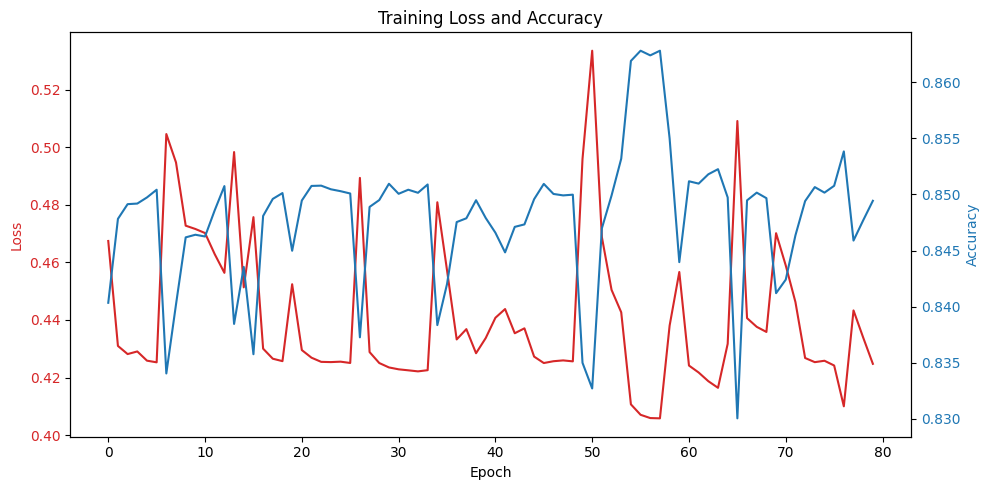

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# 1. Setup
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=0.01)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)

def train_model(model, loader, epochs=50):
    model.train()

    # Storage for plotting
    history = {
        "loss": [],
        "accuracy": []
    }

    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        total_tokens = 0

        for batch in loader:
            batch = batch.to(model.cfg.device)

            # Forward pass
            logits = model(batch)

            # Shift for next-token prediction
            predictions = logits[:, :-1, :]
            targets = batch[:, 1:]

            # Flatten for loss
            flat_predictions = predictions.reshape(-1, model.cfg.d_vocab)
            flat_targets = targets.reshape(-1)

            loss = loss_fn(flat_predictions, flat_targets)

            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Track Metrics
            total_loss += loss.item()

            # Calculate Accuracy (masking out padding/ignore_index if necessary)
            # ignore_index=0 is handled here by creating a mask
            predicted_tokens = torch.argmax(flat_predictions, dim=-1)
            mask = (flat_targets != 0)
            correct = (predicted_tokens == flat_targets) & mask

            total_correct += correct.sum().item()
            total_tokens += mask.sum().item()

        # Calculate epoch averages
        avg_loss = total_loss / len(loader)
        avg_acc = total_correct / total_tokens if total_tokens > 0 else 0

        history["loss"].append(avg_loss)
        history["accuracy"].append(avg_acc)

        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Loss: {avg_loss:.4f} | Acc: {avg_acc:.4f}")

    return history

# Run training
history = train_model(model, loader, epochs=80)

# 2. Plotting the results
def plot_metrics(history):
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot Loss
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(history['loss'], color='tab:red', label='Training Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Create a second y-axis for Accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='tab:blue')
    ax2.plot(history['accuracy'], color='tab:blue', label='Training Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.title('Training Loss and Accuracy')
    fig.tight_layout()
    plt.show()

plot_metrics(history)

In [ ]:
# def plot_metrics(history):
#     fig, ax1 = plt.subplots(figsize=(10, 6))

#     # Plot Loss on the left Y-axis
#     color = 'tab:red'
#     ax1.set_xlabel('Epochs')
#     ax1.set_ylabel('Loss', color=color)
#     ax1.plot(history['train_loss'], color=color, label='Train Loss', linewidth=2)
#     ax1.tick_params(axis='y', labelcolor=color)
#     ax1.grid(True, linestyle='--', alpha=0.6)

#     # Create a second Y-axis for Accuracy
#     ax2 = ax1.twinx()
#     color = 'tab:blue'
#     ax2.set_ylabel('Accuracy', color=color)
#     ax2.plot(history['train_acc'], color=color, label='Train Accuracy', linewidth=2)
#     ax2.tick_params(axis='y', labelcolor=color)
#     ax2.set_ylim(0, 1.05) # Accuracy is always 0 to 1

#     plt.title('Training Progress: Loss vs Per-Token Accuracy')
#     fig.tight_layout()
#     plt.show()

# plot_metrics(history)

# Testing

In [ ]:
def test_derivative(model, vocab, inverse_vocab, question, max_new_tokens=10):
    model.eval() # Set to evaluation mode

    # 1. Convert question to tokens
    tokens = [vocab.get(c, 0) for c in question]
    input_tensor = torch.tensor([tokens]).to(model.cfg.device)

    generated_text = question

    with torch.no_grad():
        for _ in range(max_new_tokens):
            # Get model's prediction for the NEXT token
            logits = model(input_tensor)

            # We only care about the prediction for the VERY LAST token we gave it
            last_token_logits = logits[0, -1, :]

            # Pick the most likely character (greedy search)
            predicted_token = torch.argmax(last_token_logits).item()

            # Translate back to character
            char = inverse_vocab.get(predicted_token, "")

            if char == "<eos>":
                break

            generated_text += char

            # Update input_tensor for the next character prediction
            new_token = torch.tensor([[predicted_token]]).to(model.cfg.device)
            input_tensor = torch.cat([input_tensor, new_token], dim=1)

    return generated_text

# Example of how to call it:
# print(test_derivative(model, vocab, inverse_vocab, "d(x^5)="))

In [ ]:
def run_eval_suite(model, vocab, inverse_vocab):
    # 1. Define the test cases: (Question, Expected Answer)
    test_cases = [
        ("d(x^3)=", "3x^2"),
        ("d(x^2)=", "2x"),
        ("d(x^250)=", "250x^249")
        # ("d(2x^9)=", "18x^8"),
        # ("d(x^7)=", "7x^6"),
        # ("d(16x^2)=", "32x")
    ]

    print(f"{'Question':<15} | {'Expected':<10} | {'Model':<10} | {'Status'}")
    print("-" * 55)

    correct_count = 0

    for question, expected in test_cases:
        # Use the inference function we defined earlier
        # We strip the question part from the output to just compare the answer
        full_output = test_derivative(model, vocab, inverse_vocab, question)
        model_answer = full_output.replace(question, "").strip()
        #model_answer = model_answer.replace("<eos>", "").strip()

        status = "✅ PASS" if model_answer == expected else "❌ FAIL"
        if model_answer == expected:
            correct_count += 1

        print(f"{question:<15} | {expected:<10} | {model_answer:<10} | {status}")
        print(full_output)

    accuracy = (correct_count / len(test_cases)) * 100
    print("-" * 55)
    print(f"Final Accuracy: {accuracy}%")

# After training, just run:
run_eval_suite(model, vocab, inverse_vocab)

Question        | Expected   | Model      | Status
-------------------------------------------------------
d(x^3)=         | 3x^2       | 3x^2       | ✅ PASS
d(x^3)=3x^2
d(x^2)=         | 2x         | 2x         | ✅ PASS
d(x^2)=2x
d(x^250)=       | 250x^249   | 252x^151   | ❌ FAIL
d(x^250)=252x^151
-------------------------------------------------------
Final Accuracy: 66.66666666666666%


# Peeking into Model

## Attention Heatmap

In [ ]:
!pip install circuitsvis

In [ ]:
import torch
import circuitsvis as cv
from IPython.display import display

# 1. Prepare your input manually using your 'vocab'
prompt = "d(x^2)="
# Convert characters to IDs based on your vocab dict
token_ids = [vocab[char] for char in prompt]
# Convert to a tensor and add a batch dimension [1, seq_len]
tokens_tensor = torch.tensor([token_ids]).to(model.cfg.device)

# 2. Convert IDs back to a list of strings for the visualizer
# CircuitsVis needs the list of labels for the axes (e.g., ['d', '(', 'x', ...])
str_tokens = [char for char in prompt]

# 3. Run with cache
model.eval()
with torch.no_grad():
    # Pass the tensor directly instead of the string
    logits, cache = model.run_with_cache(tokens_tensor)

# 4. Generate Heatmaps
for l in range(model.cfg.n_layers):
    print(f"--- Layer {l} Attention Patterns ---")

    # We use 'str_tokens' for the labels and cache for the math
    display(cv.attention.attention_heads(
        tokens=str_tokens,
        attention=cache["pattern", l][0] # [heads, seq, seq]
    ))

--- Layer 0 Attention Patterns ---


--- Layer 1 Attention Patterns ---


## Attention & Logit Lens

In [ ]:
!pip install circuitsvis

In [ ]:
import torch
import circuitsvis as cv
from transformer_lens import HookedTransformer

# 1. Load your model (replace with your path if local)
model = HookedTransformer.from_pretrained("gpt2-small")

# 2. Run with cache to capture EVERYTHING
prompt = "diff(x^4)="
logits, cache = model.run_with_cache(prompt)

# --- VISUALIZE ATTENTION ---
# This shows exactly which tokens are 'talking' to each other
str_tokens = model.to_str_tokens(prompt)
attention_pattern = cache["pattern", 0] # Layer 0
cv.attention.attention_patterns(tokens=str_tokens, attention=attention_pattern)

# --- LOGIT LENS ---
# See the 'prediction' at every layer (not just the end)
accumulated_resid, labels = cache.accumulated_resid(return_labels=True, apply_ln=True)
# Project each layer's state into the output vocabulary
layer_logits = accumulated_resid @ model.W_U + model.b_U
# Print the top predicted token for the last position at each layer
for i, label in enumerate(labels):
    top_token = layer_logits[i, 0, -1].argmax().item()
    print(f"At {label}, model thinks next token is: '{model.to_string(top_token)}'")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer
At 0_pre, model thinks next token is: ','
At 1_pre, model thinks next token is: ' the'
At 2_pre, model thinks next token is: ' the'
At 3_pre, model thinks next token is: ' the'
At 4_pre, model thinks next token is: ' the'
At 5_pre, model thinks next token is: ' the'
At 6_pre, model thinks next token is: '
'
At 7_pre, model thinks next token is: '
'
At 8_pre, model thinks next token is: '
'
At 9_pre, model thinks next token is: ' 0'
At 10_pre, model thinks next token is: '0'
At 11_pre, model thinks next token is: '0'
At final_post, model thinks next token is: '0'


## Activation Patching

In [ ]:
from transformer_lens import patching

# 'Clean' is what we want to study, 'Corrupted' is our control
clean_prompt = "diff(x^4)=" # Correct: 4x^3
corrupt_prompt = "diff(x^9)=" # Correct: 9x^8

clean_tokens = model.to_tokens(clean_prompt)
corrupt_tokens = model.to_tokens(corrupt_prompt)

# Define a metric: how much does the logit for '4' change?
target_index = model.to_single_token("4")
def patching_metric(logits):
    return logits[0, -1, target_index]

# This runs the model on corrupt_prompt, but swaps in 'clean' activations
# to see which one restores the answer '4'.
patching_results = patching.get_act_patch_resid_pre(
    model, corrupt_tokens, cache, patching_metric
)

import plotly.express as px

# 1. Convert the results to a readable format (CPU/Numpy)
# patching_results is usually a tensor of [n_layers, n_tokens]
results_cpu = patching_results.detach().cpu()

# 2. Get the token strings for the X-axis labels
str_tokens = model.to_str_tokens(corrupt_prompt)

# 3. Create the Heatmap
fig = px.imshow(
    results_cpu,
    labels=dict(x="Token Position", y="Layer", color="Logit Diff"),
    x=str_tokens,
    y=[f"Layer {i}" for i in range(model.cfg.n_layers)],
    title="Activation Patching: Which part of the model 'knows' the coefficient is 4?",
    color_continuous_scale="RdBu", # Red for positive impact, Blue for negative
    color_continuous_midpoint=0
)

# 4. Clean up the layout
fig.update_layout(
    xaxis_tickangle=-45,
    width=800,
    height=500
)

fig.show()

  0%|          | 0/84 [00:00<?, ?it/s]

## Feature Decomposition (SAEs)

In [ ]:
from sae_lens import SAEConfig, SAETrainingRunner

# Configuration for a small SAE to find 'calculus features'
cfg = SAEConfig(
    architecture = "standard",
    d_in = model.cfg.d_model,       # Input dimension from your transformer
    d_sae = model.cfg.d_model * 8,  # Number of 'features' to find
    l1_coefficient = 0.0001,        # Sparsity constraint
    # ... other training params like lr and batch_size
)

# You would then point this at your validation dataset
# runner = SAETrainingRunner(cfg, model, dataset)
# sae = runner.run()